## AGE + Motion Baseline model

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import pathlib as pal
import seaborn as sbn
from matplotlib import pyplot as plt

In [3]:
import pathlib as pal

# 📁 Base path = where this notebook lives
root_p = pal.Path().resolve()

# 📂 Input paths
pheno_p = root_p / '../../source_data/Data/ABIDE1_Pheno_PSM_matched.tsv'
null_p = root_p / '../../output_data/Results/Null'
data_t = null_p / 'Results_Instance_{}_NULL_Model_age_fd.csv'

split_net_p0_p = str(root_p / '../../output_data/Results/Discovery/split_net_{}_p0.tsv')
split_net_p1_p = str(root_p / '../../output_data/Results/Discovery/split_net_{}_p1.tsv')

# 📈 Output directory
fig_p = root_p / '../../output_data/Figures/figure_1supplementary_null'
fig_p.mkdir(parents=True, exist_ok=True)

## Load

In [4]:
def mm2in(mm):
    return mm/25.4

In [5]:
pheno = pd.read_csv(pheno_p, sep='\t')

In [6]:
# Get the results and store in array
results_array = np.stack([[pd.read_csv(str(data_t).format(instance+1, net+1)).values[:, 1:] 
                           for instance in range(100)] 
                          for net in range(18)], -1)

In [7]:
bootstrap_order = results_array[:, :, 1, 0].astype(int) - 1

In [8]:
# Find individuals that are more than once in a sample
tab = pd.read_csv(str(data_t).format(1, 1))
print([u for u in tab.bootstrap_test.unique() if tab.query('bootstrap_test == @u').shape[0] > 3])
tab.query('bootstrap_test == 212')

[np.int64(122), np.int64(296), np.int64(303), np.int64(112), np.int64(410), np.int64(85), np.int64(213), np.int64(342), np.int64(250), np.int64(61)]


,Unnamed: 0,bootstrap_train,bootstrap_test,p_values,p0_values
18,19,366,212,0.49635,0.70073


In [9]:
handles=precision_split = np.zeros(shape=(100, 7))
specificity_split = np.zeros(shape=(100, 7))
sensitivity_split = np.zeros(shape=(100, 7))

thr = 0.2

for net in range(2):
    p1 = pd.read_csv(split_net_p1_p.format(net+1), sep='\t')
    p0 = pd.read_csv(split_net_p0_p.format(net+1), sep='\t')
    for iteration in range(100):
        # Get the right bootstrap order
        bo = bootstrap_order[iteration, :]
        labels = (pheno.iloc[bo].DX_GROUP=='Autism').values.astype(int)
        prediction_region = (p1.values[:, iteration] > thr) & (p0.values[:, iteration] <= thr)

        p = sum(labels==1)
        n = sum(labels==0)
        tp = sum(labels[prediction_region]==1)
        fp = sum(labels[prediction_region]==0)
        tn = sum(labels[~prediction_region]==0)
        fn = sum(labels[~prediction_region]==1)
        # Compute stuff
        try:
            sens = tp / p
            spec = tn / n
            ppv = tp / (tp+fp)
            npv = tn / (tn + fn)
            fpr = fp / n
            fdr = fp / (fp + tp)
        except ZeroDivisionError:
            replace = 0
            sens = replace
            spec = replace
            ppv = replace
            npv = replace
            fpr = replace
            fdr = replace

        precision_split[iteration, net] = ppv
        specificity_split[iteration, net] = spec
        sensitivity_split[iteration, net] = sens


In [10]:
table_split = pd.DataFrame([(p, spec, sens, n)  
                      for net in range(2) for p, spec, sens, n in 
                      [(precision_split[i, net], 
                        specificity_split[i, net],
                        sensitivity_split[i, net],
                        f'group_{net+1}') for i in range(100)]],
                     columns=('precision', 'specificity', 'sensitivity', 'network'))

In [11]:
table_split

,precision,specificity,sensitivity,network
0,1.000000,1.000000,0.014354,group_1
1,0.857143,0.986047,0.092308,group_1
2,0.724138,0.960784,0.101942,group_1
3,0.722222,0.976852,0.067010,group_1
4,0.642857,0.975728,0.044118,group_1
...,...,...,...,...
195,0.500000,0.980861,0.019900,group_2
196,0.730769,0.963351,0.086758,group_2
197,0.888889,0.985437,0.117647,group_2
198,0.772727,0.974359,0.079070,group_2


In [12]:
precision = np.zeros(shape=(100))
specificity = np.zeros(shape=(100))
sensitivity = np.zeros(shape=(100))

thr = 0.05

for idx in range(100):
    bo = bootstrap_order[idx, :]

    labels = (pheno.iloc[bo].DX_GROUP=='Autism').values.astype(int)
    prediction_region = (p1.values[bo, idx] > thr) & (p0.values[bo, idx] <= thr)

    p = sum(labels==1)
    n = sum(labels==0)
    tp = sum(labels[prediction_region]==1)
    fp = sum(labels[prediction_region]==0)
    tn = sum(labels[~prediction_region]==0)
    fn = sum(labels[~prediction_region]==1)
    
    
    if tp+fp==0:
        ppv = 0
        fdr = 0
    else:
        ppv = tp / (tp+fp)
        fdr = fp / (fp + tp)
    # Compute stuff
    sens = tp / p
    spec = tn / n
    npv = tn / (tn + fn)
    fpr = fp / n

    precision[idx] = ppv
    specificity[idx] = spec
    sensitivity[idx] = sens

print(np.median(precision))
print(np.median(sensitivity))

0.0
0.0


In [13]:
values = np.concatenate((precision, table_split.query('network=="group_1"')['precision'].values))
names = ['baseline'] * 100 + ['HRS'] * 100

comb_table = pd.DataFrame({'PPV': values, 'model': names, 'useless': [1]*200})

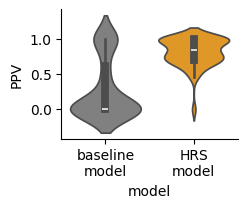

In [14]:
dpi=300
scale_factor = 1
height = 50 * scale_factor
width = 60 * scale_factor

f = plt.figure(figsize=(mm2in(width),mm2in(height)), constrained_layout=True)

ax = f.add_subplot(111)
g = sbn.violinplot(x='model', y='PPV', hue='model', data=comb_table, ax=ax, 
                  palette=sbn.color_palette(['grey', '#FE9D08']), legend=False)

sbn.despine(f, top=True, right=True)
ax.set_ylabel('PPV', fontsize=10)
ax.set_xticks([0, 1])
ax.set_xticklabels(['baseline\nmodel', 'HRS\nmodel'], fontsize=10)

f.savefig(fig_p / 'baseline.png', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)
f.savefig(fig_p / 'baseline.pdf', bbox_inches='tight', dpi=dpi, transparent=True, pad_inches=0)